# Preprocessing data for the NYC taxi tips data challenge

The objective of this notebook is to output the following data files:
- train_preprocessed.parquet
- test_preprocessed.parquet

which contains all additional columns used in our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas

from geodatasets import get_path
from shapely.geometry import Point

from utils import get_trip_duration, get_rush_hours

In [2]:
def time_transforms(_df):
    """ Add relevant columns related to time and duration. No operation is inplace. """
    _df['day_of_week'] = _df['tpep_pickup_datetime'].dt.strftime('%A')
    _df['hour'] = _df['tpep_pickup_datetime'].dt.hour

    # création de la variable is_rush_hour
    _df['is_rush_hour'] = get_rush_hours(_df['hour'], _df['day_of_week'])
    _df['is_rush_hour'] = _df['is_rush_hour'].astype(int)

    _df["duration"] = _df["tpep_dropoff_datetime"] - _df["tpep_pickup_datetime"]
    _df["duration"] = _df["duration"].dt.total_seconds() / 60

    # on supprime les variables pep_dropoff_datetime et tpep_pickup_datetime
    _df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime", "hour", "day_of_week"], inplace=True)
    
    return _df

In [3]:
df_train = pd.read_parquet("data/nyc-taxis-tips/train.parquet")
df_train = time_transforms(df_train)
# geographic data
taxi_zones = geopandas.read_file("data/nyc-taxis-tips/taxi_zones/taxi_zones.shp")
borough_categories = {"Bronx": 1, "Manhattan": 2, "Brooklyn": 3, "EWR": 4, "Staten Island": 5, "Queens": 6, "": 7}

## Handling geographic data

Retrieving the geometry (shapes, dimensions, positions etc...) of the zones where the taxis operate.

The following code cell add 4 columns to the dataframe:
- `PU_borough` = the pick-up borough name (7 values)
- `DO_borough` = the drop-off borough name (7 values)
- `PU_loc` = the coded pick up location (from 1 to 263, this is a more detail location naming than the borough)
- `DO_loc` = drop-off location

In [4]:
# fetching pick-ups and drop-offs and ensuring to project them in the correct
# coordinate system (crs = coordinate reference system).
pickup_points = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(df_train["PU_location_lon"], df_train["PU_location_lat"]),
    crs="EPSG:4326"
).to_crs(taxi_zones.crs)
dropoff_points = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(df_train["DO_location_lon"], df_train["DO_location_lat"]),
    crs="EPSG:4326"
).to_crs(taxi_zones.crs)

df_train["PU_borough"] = ""
df_train["DO_borough"] = ""
df_train["PU_loc"] = -1
df_train["DO_loc"] = -1

pickup_join = geopandas.sjoin(pickup_points, taxi_zones, how="left", predicate="within")
dropoff_join = geopandas.sjoin(dropoff_points, taxi_zones, how="left", predicate="within")
df_train["PU_loc"] = pickup_join["LocationID"].fillna(-1)
df_train["PU_borough"] = pickup_join["borough"].fillna("")
df_train["DO_loc"] = dropoff_join["LocationID"].fillna(-1)
df_train["DO_borough"] = dropoff_join["borough"].fillna("")

df_train = df_train.astype({"PU_borough": "category", "DO_borough": "category"})
df_train["PU_borough"] = df_train["PU_borough"].cat.rename_categories(borough_categories)
df_train["DO_borough"] = df_train["DO_borough"].cat.rename_categories(borough_categories)

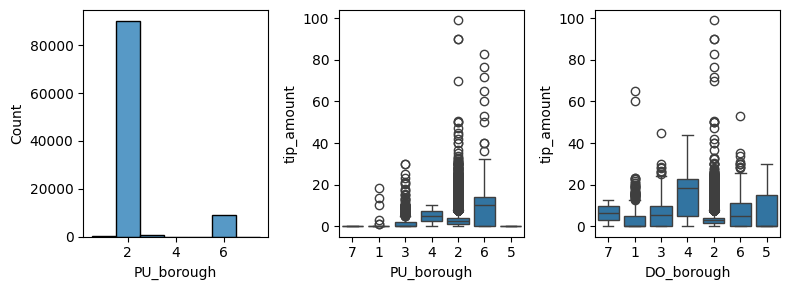

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
sns.histplot(x="PU_borough", data=df_train, ax=axes[0])
sns.boxplot(x="PU_borough", y="tip_amount", data=df_train, ax=axes[1])
sns.boxplot(x="DO_borough", y="tip_amount", data=df_train, ax=axes[2])
fig.tight_layout()
plt.show()

Plotting the pick-up and drop off locations on the map

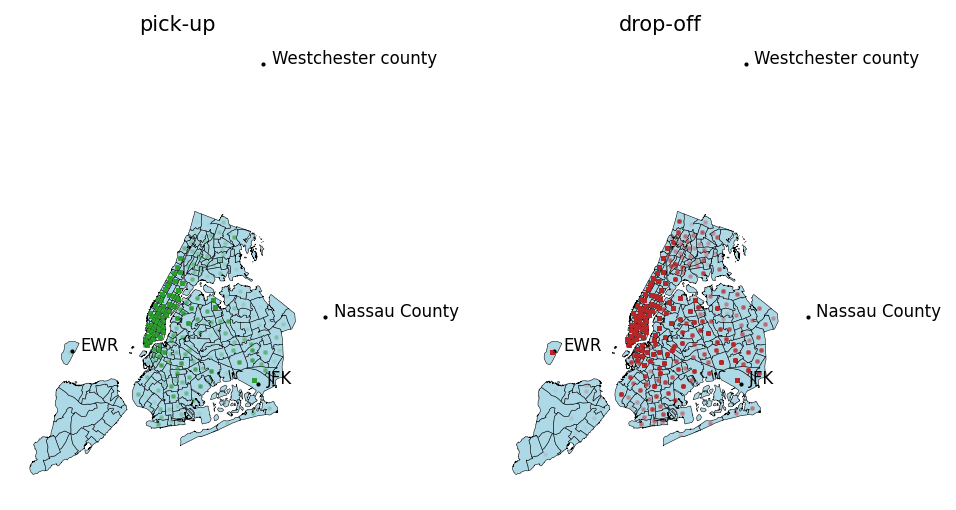

In [6]:
landmarks = [
    Point(-73.778889, 40.639722),  # JFK airport
    Point(-74.168611, 40.6925),  # Newark airport
    Point(-73.766667, 41.15),  # Westchester county
    Point(-73.6381, 40.7472),  # Nassau County
]
pts_landmarks = geopandas.GeoDataFrame({"labels": [
    "JFK",
    "EWR",
    "Westchester county",
    "Nassau County"
], "geometry": landmarks}, crs="EPSG:4326").to_crs(taxi_zones.crs)
pts_landmarks.set_index(keys="labels", drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)

# departures density
lats = df_train["PU_location_lon"].values
longs = df_train["PU_location_lat"].values
points = [Point(lats[i], longs[i]) for i in range(df_train.shape[0])]
point_gdf = geopandas.GeoDataFrame(geometry=points, crs="EPSG:4326").to_crs(taxi_zones.crs)
ax1 = taxi_zones.plot(ax=ax1, color="lightblue", edgecolor="black", lw=0.25)
pts_landmarks.plot(ax=ax1, color='k', marker='o', markersize=1, alpha=1, label='landmarks')
point_gdf.plot(ax=ax1, color='C2', marker='o', markersize=2, alpha=.03, label='departures')

for idx, landmark in pts_landmarks.iterrows():
    lx, ly = landmark["geometry"].bounds[:2]
    ax1.annotate(landmark["labels"], (lx, ly), (lx + 5e3, ly), fontsize=8)

# arrivals density
lats = df_train["DO_location_lon"].values
longs = df_train["DO_location_lat"].values
points = [Point(lats[i], longs[i]) for i in range(df_train.shape[0])]
point_gdf = geopandas.GeoDataFrame(geometry=points, crs="EPSG:4326").to_crs(taxi_zones.crs)

ax2 = taxi_zones.plot(ax=ax2, color="lightblue", edgecolor="black", lw=0.25)
pts_landmarks.plot(ax=ax2, color='k', marker='o', markersize=1, alpha=1, label='landmarks')
point_gdf.plot(ax=ax2, color='C3', marker='o', markersize=2, alpha=.03, label='arrivals')
for idx, landmark in pts_landmarks.iterrows():
    lx, ly = landmark["geometry"].bounds[:2]
    ax2.annotate(landmark["labels"], (lx, ly), (lx + 5e3, ly), fontsize=8)

ax1.axis("off")
ax2.axis("off")
ax1.set_title("pick-up", fontsize=10)
ax2.set_title("drop-off", fontdict=dict(fontsize=10), loc="center")
fig.tight_layout(w_pad=0)
plt.show()

### One-hot encoding

In [7]:
# One-hot encoding sur les colonnes spécifiées
df_train = pd.get_dummies(df_train, columns=["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type", "PU_borough", "DO_borough"], dtype=int)
df_train

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,...,PU_borough_2,PU_borough_6,PU_borough_5,DO_borough_7,DO_borough_1,DO_borough_3,DO_borough_4,DO_borough_2,DO_borough_6,DO_borough_5
0,1.0,3.30,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,0.72,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
2,2.0,7.45,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
3,1.0,1.53,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
4,1.0,1.53,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,4.38,26.1,0.0,0.5,3.00,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
99996,1.0,5.34,25.4,1.0,0.5,6.08,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,1,0,0
99997,1.0,10.10,35.5,0.0,0.5,0.00,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
99998,1.0,5.82,36.6,0.0,0.5,0.00,0.0,1.0,2.5,0.0,...,1,0,0,0,0,0,0,0,1,0


### Saving the output

In [8]:
display(df_train.columns)

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'PU_location_lat',
       'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'is_rush_hour',
       'duration', 'PU_loc', 'DO_loc', 'VendorID_1', 'VendorID_2',
       'RatecodeID_1.0', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0',
       'RatecodeID_5.0', 'RatecodeID_99.0', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'PU_borough_7', 'PU_borough_1',
       'PU_borough_3', 'PU_borough_4', 'PU_borough_2', 'PU_borough_6',
       'PU_borough_5', 'DO_borough_7', 'DO_borough_1', 'DO_borough_3',
       'DO_borough_4', 'DO_borough_2', 'DO_borough_6', 'DO_borough_5'],
      dtype='object')

In [9]:
df_train.to_parquet("data/nyc-taxis-tips/train_preprocessed.parquet")

## Applying the same to the test data

In [10]:
df_test = pd.read_parquet("data/nyc-taxis-tips/test.parquet")
df_test = time_transforms(df_test)

# fetching pick-ups and drop-offs and ensuring to project them in the correct
# coordinate system (crs = coordinate reference system).
pickup_points = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(df_test["PU_location_lon"], df_test["PU_location_lat"]),
    crs="EPSG:4326"
).to_crs(taxi_zones.crs)
dropoff_points = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(df_test["DO_location_lon"], df_test["DO_location_lat"]),
    crs="EPSG:4326"
).to_crs(taxi_zones.crs)

df_test["PU_borough"] = ""
df_test["DO_borough"] = ""
df_test["PU_loc"] = -1
df_test["DO_loc"] = -1

pickup_join = geopandas.sjoin(pickup_points, taxi_zones, how="left", predicate="within")
dropoff_join = geopandas.sjoin(dropoff_points, taxi_zones, how="left", predicate="within")
df_test["PU_loc"] = pickup_join["LocationID"].fillna(-1)
df_test["PU_borough"] = pickup_join["borough"].fillna("")
df_test["DO_loc"] = dropoff_join["LocationID"].fillna(-1)
df_test["DO_borough"] = dropoff_join["borough"].fillna("")

df_test = df_test.astype({"PU_borough": "category", "DO_borough": "category"})
df_test["PU_borough"] = df_test["PU_borough"].cat.rename_categories(borough_categories)
df_test["DO_borough"] = df_test["DO_borough"].cat.rename_categories(borough_categories)

In [11]:
display(df_test.columns)

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'is_rush_hour', 'duration', 'PU_borough',
       'DO_borough', 'PU_loc', 'DO_loc'],
      dtype='object')

### One-hot encoding

In [12]:
# One-hot encoding sur les colonnes spécifiées
df_test = pd.get_dummies(df_test, columns=["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type", "PU_borough", "DO_borough"], dtype=int)
df_test

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,...,PU_borough_2,PU_borough_6,PU_borough_5,DO_borough_7,DO_borough_1,DO_borough_3,DO_borough_4,DO_borough_2,DO_borough_6,DO_borough_5
row_ID,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.36,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,...,1,0,0,0,0,0,0,1,0,0
1,1.0,1.78,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,...,1,0,0,0,0,0,0,1,0,0
2,2.0,0.43,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,...,1,0,0,0,0,0,0,1,0,0
3,1.0,0.61,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,...,1,0,0,0,0,0,0,1,0,0
4,1.0,0.71,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627158,1.0,4.33,24.0,0.0,0.5,0.0,1.0,0.0,0.0,40.646985,...,0,1,0,0,0,0,0,0,1,0
2627159,1.0,1.70,14.9,2.5,0.5,0.0,1.0,2.5,0.0,40.759818,...,1,0,0,0,0,0,0,1,0,0
2627160,1.0,0.80,7.2,2.5,0.5,0.0,1.0,2.5,0.0,40.759818,...,1,0,0,0,0,0,0,1,0,0


### Saving the output

In [13]:
df_test.to_parquet("data/nyc-taxis-tips/test_preprocessed.parquet")